In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
tf.keras.backend.clear_session()
from tensorflow.keras.layers import Input, Softmax, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras import models, layers, optimizers, regularizers
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output


In [2]:
BATCH_SIZE = 32
SEED = 23582068
# dataset_path = "/home/jeff/Documents/Code/StridedTransformer-Pose3D/demo/dataset_pure/"
dataset_path = "/home/jeff/Documents/Code/EvoSkeleton-master/examples/keypoints_output/"

model_filepath = 'best_model.h5'
# load the model and evaluate test


In [3]:
partition = {
    "train": [],
    "val": [],
    "test": [],
}
labels = {}
random.seed(SEED)
np.random.seed(SEED)
classes = []
good = 0 
ok = 0
bad = 0
test = False
for f in os.listdir(dataset_path):
    rand = random.random()
    # if (rand < 0.05):
        # test = True
        # partition["test"].append(f)
    # elif (rand > 0.1 and rand < 0.3):
    #     test = False
    #     partition["val"].append(f)
    # else:
        # test = False
    partition["train"].append(f)
    if ("ok") in f:
        labels[f] = 1
        ok += 1
        if test: 
            classes.append(1)
    elif ("good") in f:
        labels[f] = 0
        good += 1
        if test: 
            classes.append(0)
    elif ("bad") in f:
        labels[f] = 2
        bad += 1
        if test: 
            classes.append(2)
jeff_val = "/home/jeff/Documents/Code/EvoSkeleton-master/examples/jeff_3d_kpts/"
for f in os.listdir(jeff_val):
    partition["val"].append(f)
    # partition["test"].append(f)
    if ("ok") in f:
        labels[f] = 1
        # classes.append(1)
    elif ("good") in f:
        labels[f] = 0
        # classes.append(0)
    elif ("bad") in f:
        labels[f] = 2
        # classes.append(2)

    # label is not being added because you haven't labelled test set with good, bad, ok, yet

daniel_test = "/home/jeff/Documents/Code/EvoSkeleton-master/examples/daniel_test_3d_kpts/"
for f in os.listdir(daniel_test):
    # print(f)
    partition["test"].append(f)
    if ("ok") in f:
        labels[f] = 1
        classes.append(1)
    elif ("good") in f:
        labels[f] = 0
        classes.append(0)
    elif ("bad") in f:
        labels[f] = 2
        classes.append(2)
print(good)
print(ok)
print(bad)
# print(len(partition["train"]))
# print(len(partition["val"]))
# print(len(partition["test"]))
# print(len(labels))
# labels

# labels = to_categorical(labels)

34240
38261
34288


In [4]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, dataset_dir, batch_size=64, dim=(17,3), n_classes=3, shuffle=True,):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.dataset_dir = dataset_dir
        self.list_IDs = list_IDs
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))
        # return len(self.list_IDs)

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            f = np.load(self.dataset_dir + ID)
            # reshaped = f.reshape(-1,3,1)
            # X[i,] = reshaped
            X[i] = f["arr_0"]

            # Store class
            y[i] = self.labels[ID]

        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

In [5]:
params = {
    'dim': (10,3),
    'n_classes': 3,
}

train_datagen = DataGenerator(
    partition["train"], 
    labels, 
    dataset_dir=dataset_path,
    batch_size=BATCH_SIZE,
    shuffle=True,
    **params
)
val_datagen = DataGenerator(
    partition["val"],
    labels,
    dataset_dir=jeff_val,
    batch_size=BATCH_SIZE,
    shuffle=True,
    **params
)
test_datagen = DataGenerator(
    partition["test"],
    labels,
    dataset_dir=daniel_test,
    batch_size=1,
    dim=(10,3),
    n_classes=3,
    shuffle=False
)
print(len(train_datagen))
print(len(val_datagen))
print(len(test_datagen))

3337
8
573


In [6]:
model = models.Sequential()
model.add(layers.InputLayer(input_shape=(10,3)))
# model.add(layers.MaxPooling2D((2, 2), padding='same'))
model.add(layers.Flatten())
model.add(
    layers.Dense(
        units=30, activation='relu'
        # kernel_regularizer=regularizers.L2(0.005),
        # bias_regularizer=regularizers.L2(1),
        # activity_regularizer=regularizers.L2(0.00001),
    )
)
model.add(
    layers.Dense(
        units=30, activation='relu'
        # kernel_regularizer=regularizers.L2(0.005),
        # bias_regularizer=regularizers.L2(1),
        # activity_regularizer=regularizers.L2(0.00001),
    )
)
model.add(
    layers.Dense(
        units=30, activation='relu'
        # kernel_regularizer=regularizers.L2(0.005),
        # bias_regularizer=regularizers.L2(1),
        # activity_regularizer=regularizers.L2(0.00001),
    )
)
model.add(
    layers.Dense(
        units=30, activation='relu'
        # kernel_regularizer=regularizers.L2(0.005),
        # bias_regularizer=regularizers.L2(1),
        # activity_regularizer=regularizers.L2(0.00001),
    )
)
model.add(
    layers.Dense(
        units=30, activation='relu'
        # kernel_regularizer=regularizers.L2(0.005),
        # bias_regularizer=regularizers.L2(1),
        # activity_regularizer=regularizers.L2(0.00001),
    )
)
model.add(layers.Dense(3, activation = 'softmax'))
model.summary()

# adadelta
# 30-30-30-30-30, no regularization, 4.0 LR: no bueno
# 30-30-30-30-30, no regularization, 2.0 LR: omega over
# 30-30-30-30-30, no regularization, 1.0 LR: looowwww
# 30-30-30-30-30, no regularization, 0.5 LR: droppp
# 30-30-30-30-30, no regularization, 0.25 LR: 33 lock
# 30-30-30-30-30, no regularization, 0.1 LR: jumpy
# 30-30-30-30-30, no regularization, 0.01 LR: down
# 30-30-30-30-30, no regularization, 0.001 LR: working together, significant gap

# 30-30-30, no regularization, 0.5LR: lots of overfitting
# 30-30-30, no regularization, 1.0LR: lots of overfitting
# 30-30-30, no regularization, 2.0LR: lots of overfitting
# 30-30-30, no regularization, 0.1LR: lots of overfitting, but not crazy jumps
# 30-30-30, no regularization, 0.25LR: lots of overfitting


# 30-30, no regularization, 4.0 LR: super wild swings, decent baseline
# 30-30, no regularization, 2.0 LR: wild swings + overfitting
# 30-30, no regularization, 1.0 LR: drop
# 30-30, no regularization, 0.5 LR: drop, pretty bad
# 30-30, no regularization, 0.25 LR: very goodbaseline, drops off though
# 30-30, no regularization, 0.1 LR: steady increase but significantly lower
# 30-30, no regularization, 0.01 LR: steady increase but significantly higher
# 30-30, no regularization, 0.001 LR: dipper

# 30, no regularization, 4.0 LR: jumpy bit generally ok?
# 30, no regularization, 2.0 LR: low
# 30, no regularization, 1.0 LR: loss looks promising for over time
# 30, no regularization, 0.5 LR: low
# 30, no regularization, 0.25 LR: low
# 30, no regularization, 0.1 LR: very promising
# 30, no regularization, 0.01 LR: val much higher than acc?
# 30, no regularization, 0.001 LR: going downnn


# most promising:
#  
# 30-30-30-30-30, no regularization, 0.001 LR: 
# very good, but sharply dies after ~15 epochs
# 30-30, no regularization, 0.25 LR: 
# falls before 10 epochs
# 30-30, no regularization, 0.1 LR:
# stabilizes 40%
# 30-30, no regularization, 0.01 LR:
# initially good but keeps dropping, all the way to 10%
# 30, no regularization, 0.1 LR:
# very very spiky, loss is dropping
# 30, no regularization, 0.01 LR:
# plunges down, loss is slowly dropping



# refining: 
# 30-30-30-30-30, no regularization, 0.001 LR: 
# really good val/acc, but not good testing (lots of 0 guesses), overfits past ~25 epochs, ends 70/35
# 0.002 follows much better than 0.001, overtfits past 50 epochs
# 0.003: falls after 30
# 0.004: absolutely terrible

# best: 0.002

# 0.0022:
# 0.0018:

# re-running with 0.002: seems very bad
# maybe it was 0.0002 that was good??
# YES, it was 0.0002 that was good, need to retry with nearby values


# 0.0002 w/ 5000 epochs: very good up until ~500, where it takes a sharp plunge

# 0.00022 w/ 750 epochs: 
# 0.00018 w/ 750 epochs:



# to try: 75-30 (or any other 60/90 node combo with ~5000 trainable params)
# DOESNT WORK


# best candidate for further refining:
# 5x30, 0.0002LR
# big drop at ~500 epochs, try staircase lr schedule

# starting: 0.0002, steps: 480 * 834 (480 epochs), multipler: 0.8

# 30x5 0.0002 lr doesn't seem to work well anymore
# need to try modifying # of nodes
# maybe 30x5 0.00019

2022-05-05 10:19:08.839153: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-05 10:19:08.853940: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-05 10:19:08.854143: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-05 10:19:08.855605: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 30)                0         
                                                                 
 dense (Dense)               (None, 30)                930       
                                                                 
 dense_1 (Dense)             (None, 30)                930       
                                                                 
 dense_2 (Dense)             (None, 30)                930       
                                                                 
 dense_3 (Dense)             (None, 30)                930       
                                                                 
 dense_4 (Dense)             (None, 30)                930       
                                                                 
 dense_5 (Dense)             (None, 3)                 9

In [ ]:
class PlotLearning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

In [7]:
model_filepath = 'best_model.h5'
checkpoint = keras.callbacks.ModelCheckpoint('model_saves/model{epoch:05d}.h5', period=2) 
model_save = tf.keras.callbacks.ModelCheckpoint(
    model_filepath,
    monitor = "accuracy",
    verbose = 0,
    save_best_only = True,
    save_weights_only = False,
    mode = "max",
    save_freq = "epoch"
)
val_save = tf.keras.callbacks.ModelCheckpoint(
    "best_val.h5",
    monitor = "val_accuracy",
    verbose = 0,
    save_best_only = True,
    save_weights_only = False,
    mode = "max",
    save_freq = "epoch"
)
callback = [model_save, checkpoint, val_save, PlotLearning()]

In [8]:
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=0.0002,
#     decay_steps=834*480,
#     decay_rate=0.8,
#     staircase=True
# )
model.compile(
    optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.000195),
    loss = "categorical_crossentropy",
    metrics = ["accuracy"]
)

In [9]:
history = model.fit(
    train_datagen,
    epochs=750,
    steps_per_epoch=len(train_datagen) // 4,
    validation_data=val_datagen,
    validation_steps=len(val_datagen),
    shuffle=False,
    callbacks = callback,
    use_multiprocessing=True,
    workers=4
)

Epoch 1/750
 30/834 [>.............................] - ETA: 4s - loss: 61.3688 - accuracy: 0.2760 

2022-05-05 10:19:10.782366: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


834/834 [==============================] - 6s 6ms/step - loss: 57.7883 - accuracy: 0.2684 - val_loss: 49.6189 - val_accuracy: 0.0273
Epoch 2/750
834/834 [==============================] - 5s 6ms/step - loss: 54.9868 - accuracy: 0.2636 - val_loss: 48.5156 - val_accuracy: 0.0078
Epoch 3/750
834/834 [==============================] - 6s 6ms/step - loss: 52.2915 - accuracy: 0.2626 - val_loss: 46.7423 - val_accuracy: 0.0000e+00
Epoch 4/750
834/834 [==============================] - 4s 5ms/step - loss: 49.0970 - accuracy: 0.2626 - val_loss: 44.4998 - val_accuracy: 0.0000e+00
Epoch 5/750
834/834 [==============================] - 5s 6ms/step - loss: 46.3446 - accuracy: 0.2615 - val_loss: 42.6235 - val_accuracy: 0.0000e+00
Epoch 6/750
834/834 [==============================] - 4s 5ms/step - loss: 43.6307 - accuracy: 0.2597 - val_loss: 41.2413 - val_accuracy: 0.0000e+00
Epoch 7/750
834/834 [==============================] - 5s 6ms/step - loss: 40.6475 - accuracy: 0.2636 - val_loss: 39.5948 - va

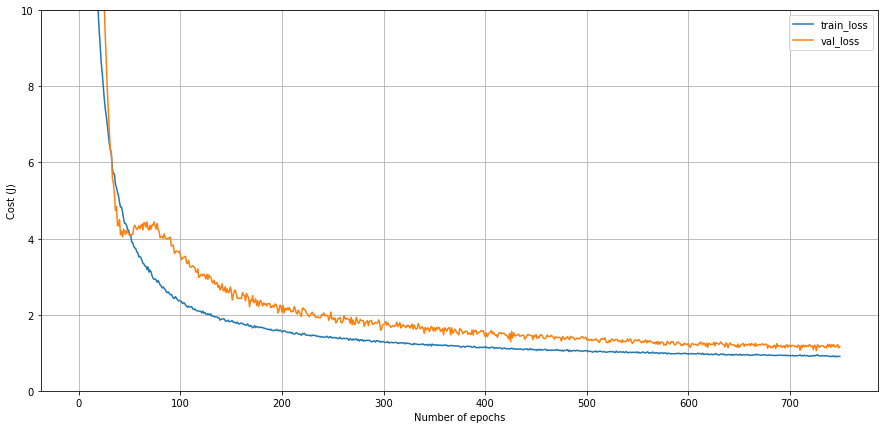

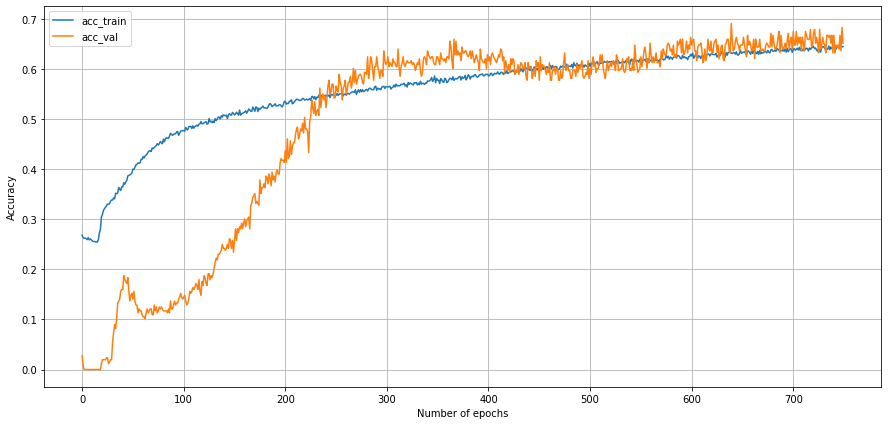

In [10]:
plt.figure(figsize = (15,7))

tr_losses = history.history['loss']
val_losses = history.history['val_loss']

tr_accs = history.history['accuracy']
val_accs = history.history['val_accuracy']

plt.plot(tr_losses, label = "train_loss")
plt.plot(val_losses, label = "val_loss")
plt.ylim(0, 10)
plt.xlabel("Number of epochs")
plt.ylabel("Cost (J)")
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize = (15,7))

plt.plot(tr_accs, label = "acc_train")
plt.plot(val_accs, label = "acc_val")
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()
plt.show()

573/573 [==============================] - 1s 1ms/step


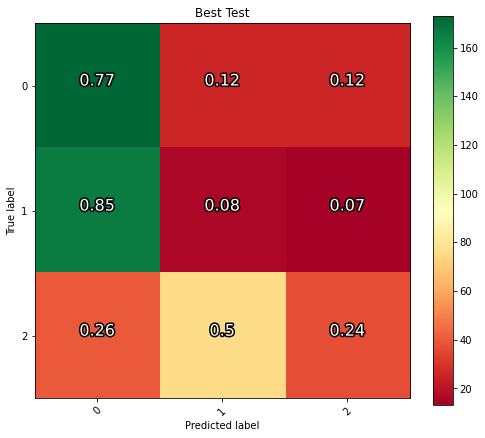

573/573 [==============================] - 1s 1ms/step


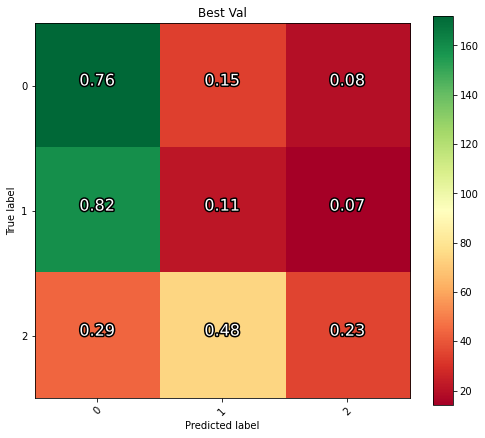

In [11]:
# best_model = tf.keras.models.load_model(model_filepath)
# test_model = tf.keras.models.load_model('model_saves/model00002.h5')
test_model = tf.keras.models.load_model('best_model.h5')
val_model = tf.keras.models.load_model('best_val.h5')

predictions = test_model.predict(
    # test_datagen,
    test_datagen,
    verbose = 1,
    # steps = (len(test_datagen))
)

predictions.squeeze().argmax(axis = -1)
classification__report = classification_report(
    classes, 
    predictions.squeeze().argmax(axis = 1)
)

confusion__matrix = confusion_matrix(
    classes,
    predictions.squeeze().argmax(axis = 1)
)

# Defining a function to print a confusion matrix
# Code snippet referenced from: https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
import matplotlib.patheffects as PathEffects
import itertools
def plot_confusion_matrix(cm,
                          classes,
                          normalise = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.RdYlGn):
    
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    if normalise:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        cm = cm.round(2)

    thresh = cm.max() / 1.1
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        txt =  plt.text(
            j, i, cm[i, j],
            horizontalalignment = "center",
            color = "white",
            size = 16
        )
        txt.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='black')])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



np.set_printoptions(precision = 2)
fig2 = plt.figure(figsize = (7,6))
plot_confusion_matrix(confusion__matrix,
                      classes = np.unique(classes),
                      normalise = True,
                      title = 'Best Test')
plt.show()

predictions = val_model.predict(
    # test_datagen,
    test_datagen,
    verbose = 1,
    # steps = (len(test_datagen))
)

predictions.squeeze().argmax(axis = -1)
classification__report = classification_report(
    classes, 
    predictions.squeeze().argmax(axis = 1)
)

confusion__matrix = confusion_matrix(
    classes,
    predictions.squeeze().argmax(axis = 1)
)

np.set_printoptions(precision = 2)
fig2 = plt.figure(figsize = (7,6))
plot_confusion_matrix(confusion__matrix,
                      classes = np.unique(classes),
                      normalise = True,
                      title = 'Best Val')
plt.show()

# DONT FORGET TO CHANGE WHICH MODEL YOU'RE LOADING